# Lab 04 : Numerical Integration

## Objectives

In this lab we will study the extremely powerful integration routine provided for us in `scipy.integrate.quad`. Despite being extremely powerful, we can make it even better by performing mathematical transformations of the integrals we wish to evaluate. **This lab is an extension of the analytic work performed in Homework 04, Problem 1 and relies on some of those results.**

We will study the simple pendulum. Despite being "simple", recall from introductory physics that we can only solve for the motion of small amplitude oscillations. Here we will study the full motion of the pendulum.

## Initialization

As always initialize, your environment now by loading all modules required and setting up the plotting environment. 

In [1]:
import numpy as np
import scipy.integrate as integ
import matplotlib.pyplot as plt
import scipy.special as sf

## Pendulum Motion

As seen in the homework, the period of the oscillations of a pendulum can be written in a few equivalent forms:
\begin{align}
\frac{T(\theta_m)}{T_0} & = \frac{\sqrt 2}{\pi} \int_0^{\theta_m} \frac{\mathrm{d}\theta}{\sqrt{\cos\theta-\cos\theta_m}}, \\
 & = \frac{2}{\pi} \int_0^{\pi/2} \frac{\mathrm{d}\psi}{\sqrt{1-\sin^2(\theta_m/2)\sin^2\psi}}, \\
 & = 1 + \sum_{n=1}^\infty a_{2n} \sin^{2n}(\theta_m/2).
\end{align}
We will label the equation (1), (2), and (3), starting from the top most equation. For the series form, you have calculated the values of the coefficients up to $a_8$. We will explore all of these forms in this lab.

### Period Calculations

Calculate the period using the three expressions above for $\theta_m$ on a grid from 1 up to and including 179 degrees in steps of 1 degree. We are faced with the question "to loop or not to loop".

For the two integrals (1) and (2) we could use `quad_vec`. To do so we would need to rewrite (1) so that $\theta_m$ is not in the limits of integration. This is easy using a simple substitution. However, the integrand has a divergence at the upper limit and it seems that `quad_vec` does not handle this as well as `quad` does. The form in (2) can directly be used with `quad_vec`. In fact, the way we would naturally write the function can be used with an array of $\theta_m$ values without any additional effort.

For the series (3) we *could* avoid writing a loop, but we have not learned how to do so. It could be done using broadcasting and other properties `np.sum`, or using `np.einsum`, and presumably in other ways. Since we have not learned about that and since this really is not a performance critical calculation it will be acceptable to use a loop.

Further, if we are already using a loop for some of the calculations, it is fine to use the same loop for all the calculations. As seen in the example this week, when we do need to write our own loops it is best to preallocate storage space for the results using `np.zeros` or `np.zeros_like`.

After performing the calculations, produce a figure showing the period calculated from the three methods as a function of the pendulum amplitude.

In [2]:
theta_m_int = np.arange(1,180)
theta_m_rad = np.deg2rad(theta_m_int)

#Equation 1
def eq1(theta, theta_m):
    return 1/np.sqrt(np.cos(theta)- np.cos(theta_m))

def period_1(theta):
    return np.sqrt(2)/np.pi * integ.quad(eq1, 0, theta, args=(theta))[0]

eq1values = np.zeros_like(theta_m_rad)
for i in range(len(theta_m_rad)):
    eq1values[i] = period_1(theta_m_rad[i])

#Equation 2
def eq2(psi):
    return (2 / np.pi) / np.sqrt(1 - (np.sin(np.deg2rad(theta_m_int) / 2)**2 * np.sin(psi)**2))
(eq2values , eq2error) = integ.quad_vec(eq2, 0 , np.pi/2)


#equation 3
n = np.arange(1,8,1)
eq3values = np.zeros_like(theta_m_rad)

#function for eq3
def inside_a(psi):
    return np.sin(psi)**(2*n)
a_intg = integ.quad_vec(inside_a,0,np.pi/2)[0]

#a^2n
a_2n = (2. / np.pi)*(sf.factorial2(2*n-1))*a_intg / ((2**n*sf.factorial(n)))
#print(a_2n)
#For loop to fill in values
for i in range(len(theta_m_rad)):
    eq3values[i] = 1 + np.sum(a_2n*(np.sin(theta_m_rad[i]/2)**(2*n)))

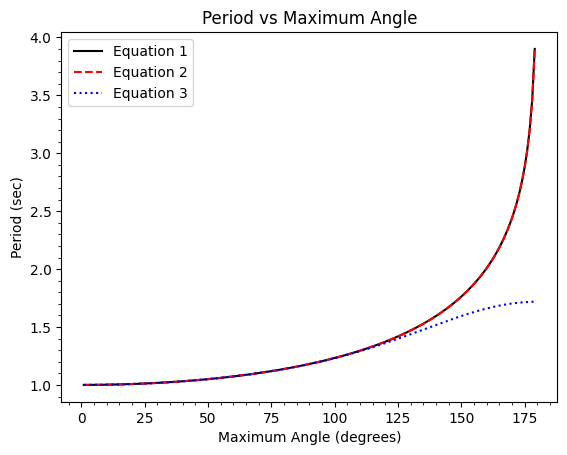

In [3]:
fig=plt.figure()
ax=fig.add_subplot(111)
plt.plot(theta_m_int,eq1values,c='black',label='Equation 1')
plt.plot(theta_m_int,eq2values,'r--',label='Equation 2')
plt.plot(theta_m_int,eq3values,'b:',label='Equation 3')
ax.set_xlabel("Maximum Angle (degrees)")
ax.set_ylabel("Period (sec)")
ax.set_title("Period vs Maximum Angle")
ax.minorticks_on()
ax.legend()

### Error in the Integrals

You should find that the two integrals agree with each other, but that the series does not agree with the integrals when the initial amplitude is large. We will look at the series in more detail below. For now let us focus on the integrals; we want to carefully look at their accuracy. As noted in the homework, the integral *can* actually be performed in terms of a special function, the elliptic integral of the first kind,
$$ \frac{T(\theta_m)}{T_0} = \frac{2}{\pi} K\! \left[ \sin^2\left( \frac{\theta_m}{2} \right) \right]. $$
The elliptic integral of the first kind can be accessed as `scipy.special.ellipk`. (*Note:* I have used a notation here consistent with SciPy, however, this is not universal. In other places you will find what we are calling $K(x^2)$ is instead written as $K(x)$. In general, before using a special function you should verify the library is using the same conventions as you are!)

We are going to produce another figure. Whenever multiple figures are produced using the same quantities you should always use the same line style or marker type, colors, *etc*. for the same quantity in each figure. This makes it much easier for the reader to connect the results among the figures. For example, this means that if you used purple horse shoes to represent the integral from Eq. (1) in your first figure, then you should also use purple horse shoes to represent the error in the integral from Eq. (1) in the figure you are about to create. (*Note:*  Do **not** use purple horse shoes as a marker.)

Produce a figure showing the fractional error in the two integrals (1) and (2). You may get a warning when you create this plot and/or one of the curves may look strange.

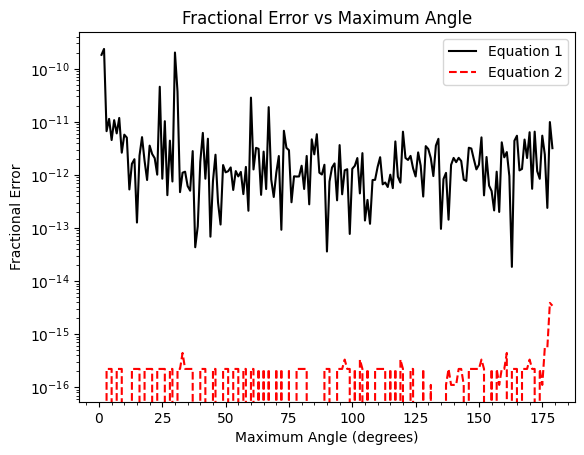

In [4]:
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(theta_m_int,np.abs(1-(eq1values/((2/np.pi)*sf.ellipk(np.sin(np.deg2rad(theta_m_int)/2)**2)))),c='black',label='Equation 1') #eq 1
ax.plot(theta_m_int,np.abs(1-(eq2values/((2/np.pi)*sf.ellipk(np.sin(np.deg2rad(theta_m_int)/2)**2)))),'r--',label='Equation 2') #eq 2
ax.set_xlabel("Maximum Angle (degrees)")
ax.set_ylabel("Fractional Error")
ax.set_title("Fractional Error vs Maximum Angle")
ax.minorticks_on()
ax.legend()
ax.set_yscale('log')

The error from the integral in Eq. (2) should look strange. You may be worried that is incorrect. Explain the source of the strange behavior of this error curve. (*Hint:* Look at the actual numerical values of the errors, not just as they show up in the plot.)

When looking at the error from the integral in equation 2, sometimes, the actual error value is smaller than the value that a float can hold. This causes limited precision issues because of truncation. Once the error becomes smaller than the machine precision, the computer thinks that the error is zero, and thus we observe jumps between machine precision and zero.

### Series Formula

Returning to the series form in (3) it is not surprising that it does a poor job at large amplitude, particularly since we truncate the sum after a few terms, at $a_8$. Explain why this is the case.

The sum has a term $\sin^{2n}(\theta_m/2)$. This term, for small $\theta_m$, does not have large contributions as n increases, since we obtain a small value to a high exponent. However, at high $\theta_m$, that term nears 1, even for higher n. This means that we will be excluding significant portions of the actual value of the sum. Thus, the truncation makes our approximation poor at high angles.

For what amplitude $\theta_m$ from the grid used above, does the fractional error in the period calculated using the series form (3) become larger than $10^{-9}$? (*Note:* The clever way to do this is to use the `where` function, though we have not discussed the `where` function yet so it is not necessary to use it here. Instead, you can just look through the list of values and find the relevant one. We will learn about the `where` function in the near future. Also note that we want the **value of the amplitude, $\theta_m$**, not the index number of where this occurs in the array you calculated.)

In [5]:
actual = (2. / np.pi)*sf.ellipk(np.sin(theta_m_rad / 2)**2)
error3 = np.abs(1 - eq3values / actual)

for i in range(len(error3)):
    if (error3[i] > 10.**(-9)):
        print(f'The first term with a large error is θ_m = {theta_m_int[i]}° with fractional error: {error3[i]}')
        break

The first term with a large error is θ_m = 40° with fractional error: 1.464022791886066e-09


## Analytic Manipulations

You may wonder why we bothered to have two different integral forms for the period, (1) and (2). Since `quad` can handle divergent integrands it can, and does, give us good answers to the integral in Eq. (1), so why bother doing the analytic work to transform the integral? We found above that the transformed integral (2) did lead to smaller errors, so that is a benefit. Even more so, the transformed integral requires far less work to compute. Thus by doing a small mathematical manipulation (as you have done in the homework) we arrive at a much easier and much more accurate formula for the computer to evaluate.

To verify this, calculate the period for $\theta_m=102^\circ$ using (1) and (2). Print the fractional errors and number of function evaluations required for each integral. Be amazed!

In [6]:
actual102=((2/np.pi)*sf.ellipk(np.sin(np.deg2rad(102)/2)**2))

#Equation 1 for 102 deg
def eq1_102(theta):
    return np.sqrt(2)/np.pi*(1/np.sqrt(np.cos(theta)- np.cos(np.deg2rad(102))))



#Equation 2 for 102 deg
def eq2_102(psi):
    return (2 / np.pi) / np.sqrt(1 - (np.sin(np.deg2rad(102) / 2)**2 * np.sin(psi)**2))


eq1result,eq1error,eq1text= integ.quad(eq1_102, 0 , np.deg2rad(102),full_output=True)
eq2result,eq2error,eq2text= integ.quad(eq2_102, 0 , np.pi/2,full_output=True)
print(f"The number of function iterations required is {eq1text['neval']} with a fractional error of {np.abs(1-eq1result/actual102)}.")
print(f"The number of function iterations required is {eq2text['neval']} with a fractional error of {np.abs(1-eq2result/actual102)}.")

The number of function iterations required is 315 with a fractional error of 2.0761170560490427e-12.
The number of function iterations required is 21 with a fractional error of 0.0.


## Member Participation

See Lab00 for instructions on turning in labs. We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who participated in this lab. Again, see Lab00 for more details. It is expected that you have read and understood those details.

bxk421, syg9, cxz520